In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# Hardcode all variables
window_size = 24
batch_size_exp = 1
epoch_exp = 10
neurons_exp = 50
predict_values_exp = 6000
lag_exp=24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled
   

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# fit an LSTM network to training data
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
''' Loading data '''
import pandas as pd
series = pd.read_excel('WA_WIND_DATA.xlsx',index_col="DateTime")
series.head()

,Pressure | (atm),Wind direction | (deg),Wind speed | (m/s),Power generated by system | (kW)
DateTime,,,,
2007-01-01 00:00:00,0.890467,104,3.429,0.00
2007-01-01 01:00:00,0.890583,106,3.579,0.00
2007-01-01 02:00:00,0.890366,102,4.307,1986.68
2007-01-01 03:00:00,0.890326,99,4.562,2597.61
2007-01-01 04:00:00,0.890549,98,4.553,2555.46


In [11]:
'''Drop all the features as we will not be having any in production'''
#del series['Air temperature | (\'C)']
del series['Pressure | (atm)']
del series['Wind speed | (m/s)']
del series['Wind direction | (deg)']
series.head()

,Power generated by system | (kW)
DateTime,
2007-01-01 00:00:00,0.00
2007-01-01 01:00:00,0.00
2007-01-01 02:00:00,1986.68
2007-01-01 03:00:00,2597.61
2007-01-01 04:00:00,2555.46


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power generated by system | (kW)
DateTime,
2009-12-31 09:00:00,2688.91
2009-12-31 10:00:00,0.00
2009-12-31 11:00:00,0.00
2009-12-31 12:00:00,0.00
2009-12-31 13:00:00,1554.51


In [13]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [15]:
# split data into train and test-sets
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
#print(test_scaled)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
20269/20269 [==============================] - 54s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 52s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 52s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107
Epoch 1/1
20269/20269 [==============================] - 53s 3ms/step - loss: 0.0107


In [17]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
for i in range(len(test_scaled)-window_size):
    window_prediction_frame = test_scaled
    test_pred = list()
    for j in range(window_size):
        X, y = window_prediction_frame[i, 0:-1], window_prediction_frame[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
        '''# Start Debug prints
        print("X: %", X)
        print("yhat: %", yhat)
        # End Debug prints'''
        # Replacing value in test scaled with the predicted value.
        test_pred = [yhat] + test_pred 
        if len(test_pred) > lag_exp+1:
            test_pred = test_pred[:-1]
        if j+1<len(window_prediction_frame):
            if j+1 > lag_exp+1:
                window_prediction_frame[j+1] = test_pred
            else:
                window_prediction_frame[j+1] = np.concatenate((test_pred, window_prediction_frame[j+1, j+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1 + window_size]
    predictions.append(yhat)
    expectations.append(expected)
    #print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [18]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))

Mean Absolute Percent Error:  99.74866041819449


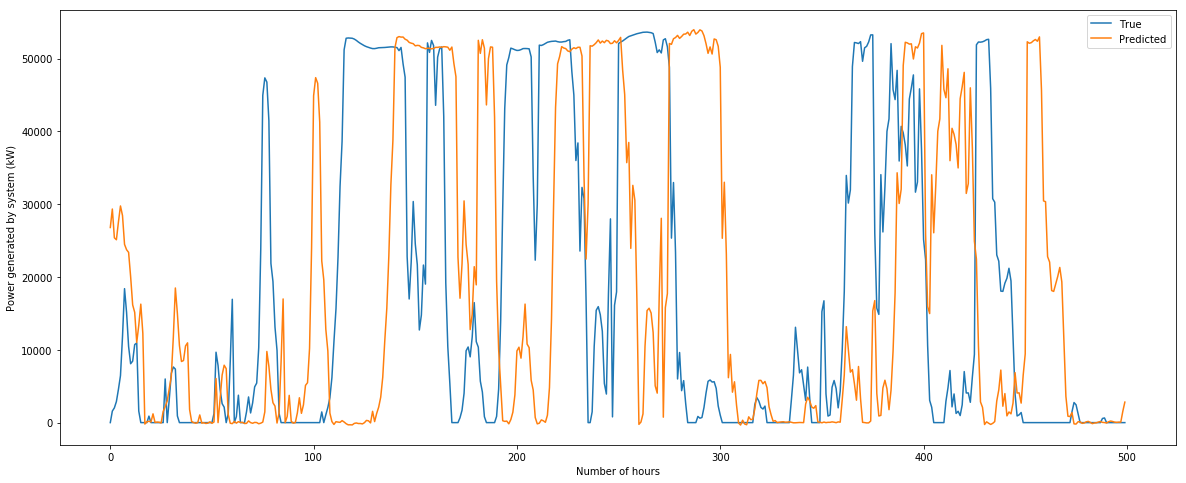

In [19]:
# line plot of observed vs predicted
fig = pyplot.figure(figsize=(20,8))
pyplot.plot(expectations[:500], label="True")
pyplot.plot(predictions[:500], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()